In [1]:
import cv2
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from misc.utils import *
from misc.preprocess import *
from misc.LaneDetector import *
import yaml
# import moviepy.editor as mpy

# Functions

In [2]:
def drawLaneLines(im_warp,L_line,R_line):

    imlines = im_warp.copy() # get a 
    im_lines = np.dstack((imlines,imlines,imlines))*255
    imlines = cv2.polylines(imlines, [L_line], False,  (255, 100,0), 30)
    imlines = cv2.polylines(imlines, [R_line], False,  (255, 100,0), 30)

    return imlines

# Track the lane lines by in bird's eye view image to find trajectory points using centroids


# get the direction of lane from the estimated lane trajectory
def getDirection(L_line,R_line):

    Lanex = (np.squeeze(L_line)[:,0] + np.squeeze(R_line)[:,0])//2
    Laney = (np.squeeze(L_line)[:,1] + np.squeeze(R_line)[:,1])//2

    # Line = np.dstack((Lanex,Laney))

    curveDir = np.poly1d(np.polyfit(Laney,Lanex,1))
    yaxis = np.linspace(Laney.min(),Laney.max()-1)
    linefit = curveDir(yaxis)
    line = np.dstack((linefit.astype(np.int32),yaxis.astype(np.int32)))

    slope = (linefit[-1] - linefit[0]) / (yaxis[-1] - yaxis[0])

    if  slope > 0.1:
        direction = 'left'
    elif  (slope > 0.01) & (slope < 0.1):
        direction = 'slight left'

    elif slope < -0.1 :
        direction = 'right'
    elif  (slope > -0.1) & (slope < -0.01):
        direction = 'slight right'

    else:
        direction = 'straight'

#     print(slope,direction)

    return line,direction

def fitLaneCurves(lX,lY,rX,rY, height,start):
    
    left_curve, right_curve = np.poly1d(np.polyfit(lY,lX,2)), np.poly1d(np.polyfit(rY,rX,2))

#     Laxis,Raxis = np.linspace(lY.min(),lY.max()-1), np.linspace(rY.min(),rY.max()-1)

    yaxis= np.linspace(start,height-1,height)

    # fit the polynomial coefficents with the linear space
    l_fit,r_fit = left_curve(yaxis),right_curve(yaxis)

    L_line, R_line = np.dstack((l_fit,yaxis)), np.dstack((r_fit,yaxis))

    return np.int32(L_line), np.int32(R_line)



def getLaneStats(line,L_line,R_line, ImageLane_width = 1280, ImageLane_height = 720, ImageLaneCenter = 600):
    # Assume
    RealLane_width = 3.7 # in meters
#     ImageLane_width = 1280 # in pixels # assume approximately
    RealLane_length = 32 # in meters
#     ImageLane_height = 720 # in pixels

    X_perpixel = RealLane_width/ImageLane_width
    Y_perpixel = RealLane_length/ImageLane_height

    # find polynomials of left and right lane w.r. to real road lane dimensions
    LeftCurve = np.polyfit(np.squeeze(L_line)[:,1]*Y_perpixel,np.squeeze(L_line)[:,0]*X_perpixel,2)
    RightCurve = np.polyfit(np.squeeze(R_line)[:,1]*Y_perpixel,np.squeeze(R_line)[:,0]*X_perpixel,2)

    # find the rad of curvature for Left and Right curves
    # https://en.wikipedia.org/wiki/Radius_of_curvature 
    # Note: Y_perpixel*ImageLane_height is the real world lane height (32m)
    df = 2*LeftCurve[0]*(Y_perpixel*ImageLane_height) + LeftCurve[1]
    d2f = 2*LeftCurve[0]
    LeftCurveRadius = np.absolute(((1 + (df)**2)**1.5)/ d2f)

    df = 2*RightCurve[0]*(Y_perpixel*ImageLane_height) + RightCurve[1]
    d2f = 2*RightCurve[0]
    RightCurveRadius = np.absolute(((1 + (df)**2)**1.5)/ d2f)

    # find car's offset with the center of lane
#     ImageLaneCenter = 600 # in pixels (chosen from first image based on observation)
    ImageCarPosition = line[0][-1][0]
    ImageLaneCenterOffset = ImageLaneCenter - ImageCarPosition
    RealLaneCenterOffset = ImageLaneCenterOffset*X_perpixel

    return LeftCurveRadius,RightCurveRadius,RealLaneCenterOffset


def createOutputFrame(inv_imColorLane_,im_binary, imL,window_img,LeftCurveRadius,RightCurveRadius,RealLaneCenterOffset,direction):
    inv_imColorLane = inv_imColorLane_.copy()
    im_binary = np.dstack((im_binary,im_binary,im_binary))*255
    im_binary = cv2.resize(im_binary, (im_binary.shape[1]//5,im_binary.shape[0]//5)) 
    window_img = cv2.resize(window_img, (window_img.shape[1]//5,window_img.shape[0]//5)) 
    imL = cv2.resize(imL, (imL.shape[1]//5,imL.shape[0]//5)) 

    ltext = 'LeftCurveRadius : ' + str(round(LeftCurveRadius)) + ' m'
    rtext = 'RightCurveRadius : ' + str(round(RightCurveRadius)) + ' m'
    ctext = 'Center Offset : ' + str(round(RealLaneCenterOffset,3)) + ' m'
    dtext = 'Direction : ' + str(direction)
    inv_imColorLane = cv2.putText(inv_imColorLane,ltext, (30,80),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,0,0),1,cv2.LINE_AA)
    inv_imColorLane = cv2.putText(inv_imColorLane,rtext, (30,110),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,0,0),1,cv2.LINE_AA)
    inv_imColorLane = cv2.putText(inv_imColorLane,ctext, (30,140),cv2.FONT_HERSHEY_COMPLEX,0.8,(255,0,0),2,cv2.LINE_AA)
    inv_imColorLane = cv2.putText(inv_imColorLane,dtext, (30,170),cv2.FONT_HERSHEY_COMPLEX,0.8,(255,0,0),2,cv2.LINE_AA)
    
    FrameMask = np.zeros_like(inv_imColorLane)

    greyStrip = np.ones((im_binary.shape[0],10,3),np.uint8)*150
    temp = np.hstack((greyStrip,im_binary))
    temp = np.hstack((temp,greyStrip))


    temp = np.hstack((temp,window_img))
    temp = np.hstack((temp,greyStrip))
    temp = np.hstack((temp,imL))
    Out = np.hstack((temp,greyStrip))

    greyStrip = np.ones((10,Out.shape[1],3),np.uint8)*150
    Out = np.vstack((greyStrip,Out,greyStrip))
    inv_imColorLane[20:20+Out.shape[0],460:460+Out.shape[1],:] = Out

    Out = cv2.add(FrameMask,inv_imColorLane)

    return Out




In [3]:

class LaneDetector():
    def __init__(self,horizon,boundaries, window_size, mva_filter,mva_win, lanecenter ):
        
        # MOVING AVERAGE OBJECTS
        self.l_line_mva = None
        self.r_line_mva = None        
        self.r_mean = None
        self.l_mean = None
        # MEMORY VARIABLES
        self.e_L_line = []
        self.e_R_line = []
        self.prevL_line = None
        self.prevR_line = None
        # PIPELINE VARIABLES
        self.startFlag = True
        self.grad = False
        self.horizon = horizon
        self.boundaries = boundaries
        self.window_size = window_size
        self.mva_filter = mva_filter
        self.mva_win = mva_win
        self.lanecenter = lanecenter
        
        
    def PerspectiveTransform(self,im,inverse=False, ismanual = True):
    
        d_bot1, d_bot2, d_top1, d_top2 = self.boundaries

        im_print = np.copy(im)
        height,width = im.shape[:2]


        minLineLength = 300
        if ismanual == False:
            pts = getROI_points(im_print, self.horizon, minLineLength ,d_bot1, d_bot2,d_top1,d_top2) # challenge video
        else:
            pts = np.array([[d_bot1,height],[d_top1,self.horizon],[d_top2,self.horizon], [d_bot2, height]], np.float32)
    #         pts = np.array([[a,height],[int(width*b - d_top1),self.horizon],[int(width*(1-b)+d_top2),self.horizon], [width-a, height]], np.float32)

        dst_w, dst_h =width, height
        c =200
        res = np.array([[c, dst_h], [c, 0], [width-c, 0], [width-c, dst_h]], np.float32)
    #     res = np.array([[(a+100), height], [(a+100), 0], [width-(a+100), 0], [width-(a+100), height]], np.float32)

        if len(im_print.shape)<3:
            cv2.polylines(im_print,[np.int32(pts)],True,1, 10)    
        else:
            cv2.polylines(im_print,[np.int32(pts)],True,(255,0,0), 10)

        if inverse == True:
            M = cv2.getPerspectiveTransform(res, pts)
            im_warp = cv2.warpPerspective(im, M, (width,height), flags=cv2.INTER_LINEAR)

        else:   
            M = cv2.getPerspectiveTransform(pts, res)
            im_warp = cv2.warpPerspective(im, M, (dst_w,dst_h), flags=cv2.INTER_LINEAR)

        return im_warp, im_print
    
    def windowTracer(self, im_warp, thresh = 200,emptyCount = 8):
        out_img = np.dstack((im_warp, im_warp, im_warp))*255
        height,width = im_warp.shape[:2]
        distribution  = np.sum(im_warp[height//3:,:],axis=0)
        mdpt = int(len(distribution)//2) # find midpoint of the distribution alonf x axis    
        Xcleft = np.argmax(distribution[:mdpt]) # find left lane peak as p1
        Xcright = np.argmax(distribution[mdpt:]) + mdpt # find right lane peak as p2 

        #########################################################################################
        ###################### to restrict lane widths from changing suddenly####################
        #########################################################################################
        if self.startFlag ==True:
            print('initialised moving average')
            self.l_mean = MovingAverage(window_size = 10)
            self.r_mean = MovingAverage(window_size = 10)
            meanXcleft = Xcleft
            meanXcright = Xcright
            self.startFlag = False
        #     print('startFlag, mean = ',meanXcleft,meanXcright)
        else:
            meanXcleft= self.l_mean.getmean()
            meanXcright= self.r_mean.getmean()
        #     print('not startFlag, mean = ',meanXcleft,meanXcright)

        if abs(Xcleft - meanXcleft) > thresh:
        #     print('error left :' ,abs(Xcleft - meanXcleft))
            Xcleft = meanXcleft
            badLane_left = True
        else:
            badLane_left = False
            self.l_mean.add_values(Xcleft)

        if abs(Xcright - meanXcright) > thresh:
        #     print('error right :', abs(Xcright - meanXcright))
            Xcright = meanXcright
            badLane_right  = True
        else:
            badLane_right  = False
            self.r_mean.add_values(Xcright)

        print('w/o lane width restriction : ', np.argmax(distribution[:mdpt]), np.argmax(distribution[mdpt:]) + mdpt ,'-##- with lane width restriction : ', Xcleft,Xcright)

        if badLane_right or badLane_left:
            print( 'Bad lanes found, will use previous data' )
            dummy = []  
            return [dummy, dummy], [dummy, dummy], out_img

        ######################################################################################### 
        #######################  perform window tracing #########################################
        #########################################################################################

        # finds all non zero pixels in the Bmap
        Y_nz,X_nz = im_warp.nonzero()

        L_lane_inds = []
        R_lane_inds = []

        L_centrds = [(Xcleft,height)]
        R_centrds = [(Xcright,height)]

        # B maps consists of both lane pixels and the distorted back ground content.
        ##  Traverse upwards window-wise to track the lane pixels from the overall B maps
        n_windows = 10
        H_win = int(height//n_windows) 
        W_win=self.window_size

        LemptyboxCounter = 0
        RemptyboxCounter = 0
        for win in range(n_windows):
            # define window Y boundaries
            Ywin_start = height - (win+1)*H_win
            Ywin_end = height - (win)*H_win

            # define left window X boundaries 
            margin = W_win//2
            Xwin_Lstart, Xwin_Lend = int(Xcleft - margin), int(Xcleft + margin)
            # define right window X boundaries 
            Xwin_Rstart, Xwin_Rend = int(Xcright - margin), int(Xcright + margin)

            lBox = np.array([ [Xwin_Lstart,Ywin_start],[Xwin_Lstart,Ywin_end],[Xwin_Lend,Ywin_end],[Xwin_Lend,Ywin_start] ],np.int32)
            rBox = np.array([ [Xwin_Rstart,Ywin_start],[Xwin_Rstart,Ywin_end],[Xwin_Rend,Ywin_end],[Xwin_Rend,Ywin_start] ],np.int32)

            lBox,rBox = lBox.reshape((-1,1,2)),rBox.reshape((-1,1,2))
            out_img = cv2.polylines(out_img,[lBox],True,(0,255,255),3)
            out_img = cv2.polylines(out_img,[rBox],True,(0,255,255),3)

            '''
            For a given window positions in Bmap Find the nonzero lane pixels within the left and right windows:

            Y_nz and X_nz are list of indices of non zero pixels in our entire B-map. 
            Any non zero pixel in Bmap is present in X_nz[i],Y_nz[i] (i ranges 0-len(X_nz or Y_nz))

            Here, we need to find out the Y_nz and X_nz elements inside the window boundaries.

            Lwin_nz, Rwin_nz initially returns a boolean list. 
            True: indices of nonzero pixels inside the window boundaries. 
            False: indices of nonzero pixels outside window boundaries
            We find the  nonzero() of the boolean list to return indices that are inside the window.
            X_nz(Lwin_nz) gives Bmap non-zero pixel location that are inside the window
            '''

            # Find non zero pixel locations inside the left and right windows
            # here, Lwin_nz and Rwin_nz contains the indices of X_nz that are within the current window
            Lwin_nz = (Y_nz >= Ywin_start)&(Y_nz <= Ywin_end)&(X_nz >= Xwin_Lstart)&(X_nz <= Xwin_Lend) # returns boolean list
            Lwin_nz = Lwin_nz.nonzero()[0] # pick the Bmap nz pixel indices belonging inside window

            Rwin_nz =(Y_nz >= Ywin_start)&(Y_nz <= Ywin_end)&(X_nz >= Xwin_Rstart)&(X_nz <= Xwin_Rend) # return boolean list
            Rwin_nz = Rwin_nz.nonzero()[0] # pick the Bmap nz pixel indices belonging inside window

            # Xaxis updation:
            # the mean of X_nz pixels inside the left and right windows are found. 
            # This mean is the X axis location of the left and right lanes
            # Xcleft and Xcright are updated with the mean location of pixels inside the window
            if len(Rwin_nz)>100:
                Xcright = int(np.mean(X_nz[Rwin_nz]))
            else:
                # empty rbox
                RemptyboxCounter+=1

            if len(Lwin_nz)>100:
                Xcleft = int(np.mean(X_nz[Lwin_nz]))
            else:
                # empty lbox
                LemptyboxCounter+=1

            L_centrds.append((Xcleft,Ywin_start))
            R_centrds.append((Xcright,Ywin_start))

            # append the list of X_nz[i], Y_nz[i] indices i inside the current left and right windows
            L_lane_inds.append(Lwin_nz)
            R_lane_inds.append(Rwin_nz)

        L_lane_inds = np.concatenate(L_lane_inds)
        R_lane_inds = np.concatenate(R_lane_inds)
        # obtain  left and right lane points
        lX,lY = X_nz[L_lane_inds],Y_nz[L_lane_inds]
        rX,rY = X_nz[R_lane_inds],Y_nz[R_lane_inds]

        if LemptyboxCounter > emptyCount:
            print('bad data at left lane')
            lX,lY = [],[]
        if RemptyboxCounter > emptyCount:
            print('bad data at right lane')
            rX, rY = [],[]

        return [lX,lY],[rX,rY], out_img
    def drawLaneArea(self,im,imL_,L_line,R_line,area_height):
        imL = imL_.copy()
        l1,r1 = L_line[0][area_height:],np.flipud(R_line[0][area_height:]) # get the last 15 points of left and right lines in right order
        pts = np.vstack((l1,r1)) # stack then in correct order
        imColorLane = cv2.fillPoly(imL, [pts], (80,227, 227)) #get ColorLanes
        inv_imColorLane,_ = self.PerspectiveTransform(imColorLane, inverse=True, ismanual = True)
        inv_imColorLane = cv2.addWeighted(im, 1, inv_imColorLane, 0.5, 0)    
        return inv_imColorLane

    def processLane(self, im):
        if self.startFlag ==True:
            self.l_line_mva = MovingAverage(window_size = self.mva_win)
            self.r_line_mva = MovingAverage(window_size = self.mva_win)
            
        
        im_warp, _ = self.PerspectiveTransform(im, inverse=False, ismanual = True)  
        out = mask(im, self.grad)
        out_warp = mask(im_warp, grad = self.grad)

        [lX,lY],[rX,rY], window_img = self.windowTracer(out_warp) # startFlag becomes False in here.
        print("mean Window lengths", len(self.l_mean), len(self.r_mean))
        print('No of lane pixels detected: ', len(lX), len(lY), len(rX), len(rY))

        ############################### OBTAIN LANE LINES #######################################
        ############################### vanilla method #######################################
        
        if mva_filter:
            ############################### moving average method #######################################
                    # if bad data occurs,  use previous polynomials - moving average approach                     
            if len(lX) and len(lY) and len(rX) and len(rY):
                L_line, R_line = fitLaneCurves(lX,lY,rX,rY, out_warp.shape[0],0) 
                if (len(self.l_line_mva) <1) or (np.linalg.norm((L_line - self.l_line_mva.getmean()).squeeze(), ord = 1) < 30000):
                    self.l_line_mva.add_values(L_line)

                if (len(self.r_line_mva) <1) or (np.linalg.norm((R_line - self.r_line_mva.getmean()).squeeze(), ord = 1) < 30000):
                    self.r_line_mva.add_values(R_line)

                self.e_L_line.append(np.linalg.norm((L_line - self.l_line_mva.getmean()).squeeze(), ord = 1))
                self.e_R_line.append(np.linalg.norm((R_line - self.r_line_mva.getmean()).squeeze(), ord = 1))
                print('added mean lines')
            else:
                L_line, R_line = self.l_line_mva.getmean(), self.r_line_mva.getmean()
            L_line, R_line = self.l_line_mva.getmean(), self.r_line_mva.getmean()
        else:
            # if bad data occurs,  use previous polynomials - vanilla approach                     
            if len(lX) and len(lY) and len(rX) and len(rY):
                L_line, R_line = fitLaneCurves(lX,lY,rX,rY, out_warp.shape[0],0)
                self.prevL_line,self.prevR_line = L_line, R_line
            else:
                L_line, R_line = self.prevL_line,self.prevR_line             
                
        ############################### OBTAIN LANE LINES #######################################
        imLines = drawLaneLines(out_warp,L_line,R_line) # draw the estimated lane line 
        line,direction = getDirection(L_line,R_line) # get the center line with mean of left and right lanes

        inv_imLines1, _ = self.PerspectiveTransform(imLines, inverse=True, ismanual = True) # get the unwarped estimated lane line 
        imL = np.dstack((imLines,imLines,imLines))
        area_h = 200
        inv_imColorLane = self.drawLaneArea(im,imL,L_line,R_line,area_h)
        # draw center Line
        imL = cv2.polylines(imL, [line], False,  (0,200, 50), 30)
        LeftCurveRadius,RightCurveRadius,RealLaneCenterOffset = getLaneStats(line,L_line,R_line,
                                                                             ImageLane_width = imL.shape[1], ImageLane_height = imL.shape[0],
                                                                             ImageLaneCenter = self.lanecenter ) # calculate lane statistics
        outputFrame = createOutputFrame(inv_imColorLane,out, imL, window_img, LeftCurveRadius, RightCurveRadius, RealLaneCenterOffset, direction)

        return outputFrame


In [4]:
yaml_path = "./Project2_Dataset2/Project2_Dataset2/data_1/camera_params.yaml"
with open(yaml_path) as f:
    data = yaml.load(f, Loader=yaml.FullLoader)
    
K = np.array([np.float32(value) for value in data['K'].split()]).reshape(3,3)
kC = np.array([np.float32(value) for value in data['D'].split()]).reshape(1,-1)

imgs =  StitchImages(K,kC, datapath = "./Project2_Dataset2/Project2_Dataset2/data_1/data/*png")

In [9]:
imgs[0].shape, outputs[0].shape

((512, 1392, 3), (512, 1392, 3))

In [17]:
boundaries = (150,950,610,710) 
horizon = 265
window_size = 200
mva_filter = True
mva_win = 5
lanecenter = 600

detector = LaneDetector(horizon, boundaries, window_size, mva_filter, mva_win, lanecenter)
outputs = []
h, w = imgs[0].shape[:2]
print(h,w)
SaveFileName = 'projectoutput.mp4'
result = cv2.VideoWriter(SaveFileName,  
                        cv2.VideoWriter_fourcc(*'DIVX'), 
                        30, (w, h)) 

for i, im in enumerate(imgs):
    print(i, '####################################')
    out = detector.processLane(im)

    cv2.imshow('Lanes', rgb(out))
    result.write(rgb(np.uint8(out)))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    outputs.append(np.uint8(out))
result.release()
cv2.destroyAllWindows()    

512 1392
0 ####################################
initialised moving average
w/o lane width restriction :  250 1141 -##- with lane width restriction :  250 1141
mean Window lengths 1 1
No of lane pixels detected:  10409 10409 15553 15553
added mean lines
1 ####################################
w/o lane width restriction :  227 1150 -##- with lane width restriction :  227 1150
mean Window lengths 2 2
No of lane pixels detected:  12864 12864 15398 15398
added mean lines
2 ####################################
w/o lane width restriction :  238 1161 -##- with lane width restriction :  238 1161
mean Window lengths 3 3
No of lane pixels detected:  15588 15588 13824 13824
added mean lines
3 ####################################
w/o lane width restriction :  179 1164 -##- with lane width restriction :  179 1164
mean Window lengths 4 4
No of lane pixels detected:  18028 18028 12538 12538
added mean lines
4 ####################################
w/o lane width restriction :  184 1166 -##- with lane wid

In [4]:
K = np.array([9.037596e+02, 0.000000e+00, 6.957519e+02,
              0.000000e+00, 9.019653e+02, 2.242509e+02,
              0.000000e+00, 0.000000e+00, 1.000000e+00]).reshape(3,3)

kC = np.array([-3.639558e-01, 1.788651e-01, 6.029694e-04, -3.922424e-04, -5.382460e-02]).reshape(1,-1)

path = "./Project2_Dataset2/data_2/challenge_video.mp4"
imgs = vidRead(K,kC, path)
print(len(imgs))

473


In [30]:
im = imgs[0]

(-0.5, 3879.5, 719.5, -0.5)

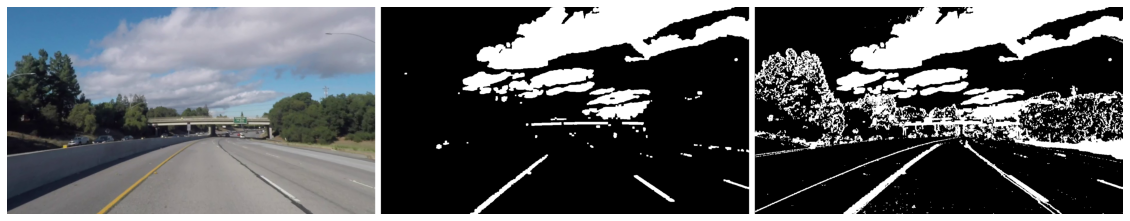

In [31]:


def plotImages(im,binary_,binary):
    partition = np.ones((im.shape[0],20), dtype=np.uint16)*255
    partition = np.dstack((partition,partition,partition))
    out = np.hstack((im,partition,binary_,partition,binary))
    return out

binary = binary2color(mask(im,2,True))
binary_ = binary2color(mask(im,1,False))

out = plotImages(im,binary_,binary)

plt.figure(figsize = (20,20))
plt.imshow(out)
plt.axis('off')
# plt.savefig('./Outputs/gradThresh.png', bbox_inches='tight', pad_inches = 0)

(-0.5, 3879.5, 719.5, -0.5)

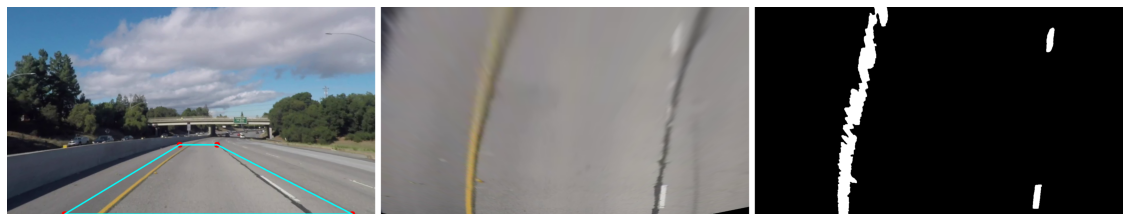

In [32]:
def drawCircles(im,pts, t = 10):
    im_print = im.copy()
    for pt in pts:
        a,b = pt
        cv2.circle(im_print,(a,b),t,(255,0,0),-1)
    return im_print


def PerspectiveTransform_(im, horizon, boundaries, inverse=False, ismanual = True):

    d_bot1, d_bot2, d_top1, d_top2 = boundaries

    im_print = np.copy(im)
    height,width = im.shape[:2]


    minLineLength = 300
    if ismanual == False:
        pts = getROI_points(im_print, horizon, minLineLength ,d_bot1, d_bot2,d_top1,d_top2) # challenge video
    else:
        pts = np.array([[d_bot1,height],[d_top1, horizon],[d_top2,horizon], [d_bot2, height]], np.float32)
#         pts = np.array([[a,height],[int(width*b - d_top1),self.horizon],[int(width*(1-b)+d_top2),self.horizon], [width-a, height]], np.float32)

    dst_w, dst_h =width, height
    c =200
    res = np.array([[c, dst_h], [c, 0], [width-c, 0], [width-c, dst_h]], np.float32)
#     res = np.array([[(a+100), height], [(a+100), 0], [width-(a+100), 0], [width-(a+100), height]], np.float32)

    if len(im_print.shape)<3:
#         cv2.polylines(im_print,[np.int32(pts)],True,1, 10)        
        im_print = drawCircles(im,pts)        
    else:
        im_print = drawCircles(im,pts)
        cv2.polylines(im_print,[np.int32(pts)],True,(0,255,255), 3)
        
    if inverse == True:
        M = cv2.getPerspectiveTransform(res, pts)
        im_warp = cv2.warpPerspective(im, M, (width,height), flags=cv2.INTER_LINEAR)

    else:   
        M = cv2.getPerspectiveTransform(pts, res)
        im_warp = cv2.warpPerspective(im, M, (dst_w,dst_h), flags=cv2.INTER_LINEAR)

    return im_warp, im_print

boundaries = (200,1200,600,730) 
horizon = 480
im_warp,im_print = PerspectiveTransform_(im, horizon, boundaries, inverse=False, ismanual = True)

binary_warp = binary2color(mask(im_warp,2, False)) 
out = plotImages(im_print,im_warp,binary_warp)

plt.figure(figsize = (20,20))
plt.imshow(out)
plt.axis('off')
# plt.savefig('./Outputs/rectify.png', bbox_inches='tight', pad_inches = 0)

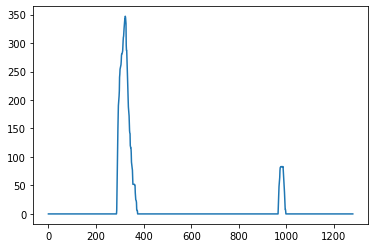

In [33]:
out = binary_warp[:,:,0]//255

distribution  = np.sum(out[out.shape[0]//2:,:],axis=0)
mdpt = int(len(distribution)//2) # find midpoint of the distribution alonf x axis    
Xcleft = np.argmax(distribution[:mdpt]) # find left lane peak as p1
Xcright = np.argmax(distribution[mdpt:]) + mdpt # find right lane peak as p2 

plt.plot(distribution)
# plt.savefig('./Outputs/LaneDist.png', bbox_inches='tight', pad_inches = 0)

(-0.5, 1279.5, 719.5, -0.5)

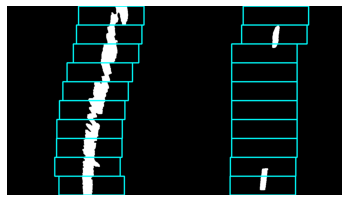

In [34]:
def windowTracer_(im_warp, thresh = 200,emptyCount = 8):

    out_img = np.dstack((im_warp, im_warp, im_warp))*255
    
    height,width = im_warp.shape[:2]
    distribution  = np.sum(im_warp[height//3:,:],axis=0)
    mdpt = int(len(distribution)//2) # find midpoint of the distribution alonf x axis    
    Xcleft = np.argmax(distribution[:mdpt]) # find left lane peak as p1
    Xcright = np.argmax(distribution[mdpt:]) + mdpt # find right lane peak as p2 


    ######################################################################################### 
    #######################  perform window tracing #########################################
    #########################################################################################

    # finds all non zero pixels in the Bmap
    Y_nz,X_nz = im_warp.nonzero()

    L_lane_inds = []
    R_lane_inds = []

    L_centrds = [(Xcleft,height)]
    R_centrds = [(Xcright,height)]

    # B maps consists of both lane pixels and the distorted back ground content.
    ##  Traverse upwards window-wise to track the lane pixels from the overall B maps
    n_windows = 10
    H_win = int(height//n_windows) 
#         W_win=self.window_size
    W_win=250

    LemptyboxCounter = 0
    RemptyboxCounter = 0
    for win in range(n_windows):
        # define window Y boundaries
        Ywin_start = height - (win+1)*H_win
        Ywin_end = height - (win)*H_win

        # define left window X boundaries 
        margin = W_win//2
        Xwin_Lstart, Xwin_Lend = int(Xcleft - margin), int(Xcleft + margin)
        # define right window X boundaries 
        Xwin_Rstart, Xwin_Rend = int(Xcright - margin), int(Xcright + margin)

        lBox = np.array([ [Xwin_Lstart,Ywin_start],[Xwin_Lstart,Ywin_end],[Xwin_Lend,Ywin_end],[Xwin_Lend,Ywin_start] ],np.int32)
        rBox = np.array([ [Xwin_Rstart,Ywin_start],[Xwin_Rstart,Ywin_end],[Xwin_Rend,Ywin_end],[Xwin_Rend,Ywin_start] ],np.int32)
        lBox,rBox = lBox.reshape((-1,1,2)),rBox.reshape((-1,1,2))
        out_img = cv2.polylines(out_img,[lBox],True,(0,255,255),3)
        out_img = cv2.polylines(out_img,[rBox],True,(0,255,255),3)
#         out_img = cv2.circle(out_img,(Xcleft,Xcright),15,(255,0,0),3)

        '''
        For a given window positions in Bmap Find the nonzero lane pixels within the left and right windows:

        Y_nz and X_nz are list of indices of non zero pixels in our entire B-map. 
        Any non zero pixel in Bmap is present in X_nz[i],Y_nz[i] (i ranges 0-len(X_nz or Y_nz))

        Here, we need to find out only the Y_nz and X_nz elements inside the window boundaries.

        The variables Lwin_nz, Rwin_nz initially returns a boolean list. 
            if True: indices of nonzero pixels inside the window boundaries. 
            if False: indices of nonzero pixels outside window boundaries

        We find the  nonzero() (i.e True values) of these two boolean lists (Lwin_nz, Rwin_nz) to return indices that are inside the window.
        X_nz(Lwin_nz) gives Bmap non-zero pixel location that are inside the window
        '''

        # Find non zero pixel locations inside the left and right windows
        # here, Lwin_nz and Rwin_nz contains the indices of X_nz that are within the current window
        Lwin_nz = (Y_nz >= Ywin_start)&(Y_nz <= Ywin_end)&(X_nz >= Xwin_Lstart)&(X_nz <= Xwin_Lend) # returns boolean list
        Lwin_nz = Lwin_nz.nonzero()[0] # pick the Bmap nz pixel indices belonging inside window

        Rwin_nz =(Y_nz >= Ywin_start)&(Y_nz <= Ywin_end)&(X_nz >= Xwin_Rstart)&(X_nz <= Xwin_Rend) # return boolean list
        Rwin_nz = Rwin_nz.nonzero()[0] # pick the Bmap nz pixel indices belonging inside window

        # Xaxis updation:
        # the mean of X_nz pixels inside the left and right windows are found. 
        # This mean is the X axis location of the left and right lanes
        # Xcleft and Xcright are updated with the mean location of pixels inside the window
        if len(Rwin_nz)>100:
            Xcright = int(np.mean(X_nz[Rwin_nz]))
        else:
            # empty rbox
            RemptyboxCounter+=1

        if len(Lwin_nz)>100:
            Xcleft = int(np.mean(X_nz[Lwin_nz]))
        else:
            # empty lbox
            LemptyboxCounter+=1

        L_centrds.append((Xcleft,Ywin_start))
        R_centrds.append((Xcright,Ywin_start))

        # append the list of X_nz[i], Y_nz[i] indices i inside the current left and right windows
        L_lane_inds.append(Lwin_nz)
        R_lane_inds.append(Rwin_nz)

    L_lane_inds = np.concatenate(L_lane_inds)
    R_lane_inds = np.concatenate(R_lane_inds)
    # obtain  left and right lane points
    lX,lY = X_nz[L_lane_inds],Y_nz[L_lane_inds]
    rX,rY = X_nz[R_lane_inds],Y_nz[R_lane_inds]

    if LemptyboxCounter > emptyCount:
        print('bad data at left lane')
        lX,lY = [],[]
    if RemptyboxCounter > emptyCount:
        print('bad data at right lane')
        rX, rY = [],[]

    return [lX,lY],[rX,rY], out_img

[lX,lY],[rX,rY], out_img = windowTracer_(out)
plt.imshow(out_img)
plt.axis('off')
# plt.savefig('./Outputs/SearchWindow_fail.png', bbox_inches='tight', pad_inches = 0)

(-0.5, 3879.5, 719.5, -0.5)

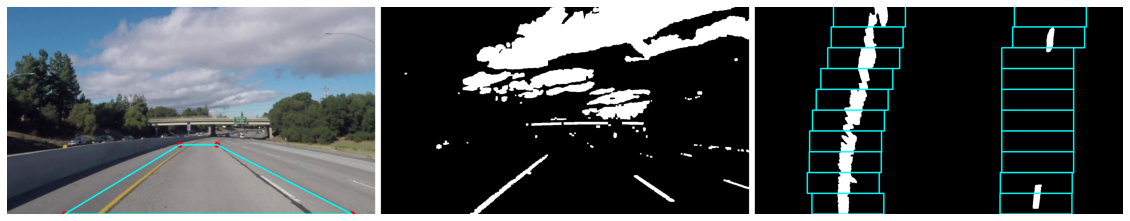

In [35]:
plt.figure(figsize = (20,20))
plt.imshow(plotImages(im_print,binary_,out_img))
plt.axis('off')

# plt.savefig('./Outputs/SearchWindow_fail.png', bbox_inches='tight', pad_inches = 0)

In [36]:
L_line, R_line = fitLaneCurves(lX,lY,rX,rY, out.shape[0],0)

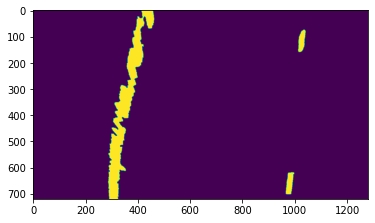

In [43]:
plt.imshow(out)

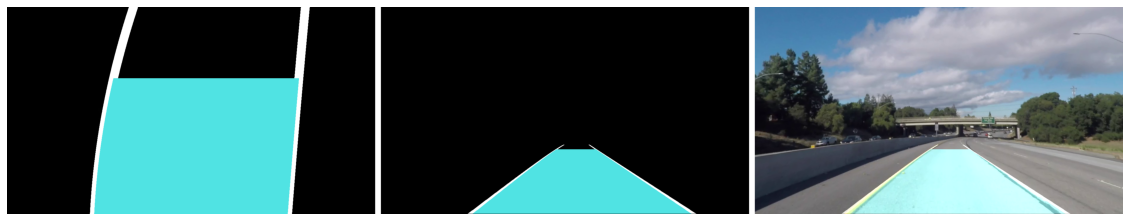

In [65]:
def drawLaneArea(im,imL_,L_line,R_line,area_height, horizon, boundaries):
    imL = imL_.copy()
    l1,r1 = L_line[0][area_height:],np.flipud(R_line[0][area_height:]) # get the last 15 points of left and right lines in right order
    pts = np.vstack((l1,r1)) # stack then in correct order
    imColorLane = cv2.fillPoly(imL, [pts], (80,227, 227)) #get ColorLanes
    inv_imColorLane,_ =     PerspectiveTransform_(im, horizon, boundaries, inverse=True, ismanual = True)
#     inv_imColorLane,_ = self.PerspectiveTransform(imColorLane, inverse=True, ismanual = True)
    inv_imColorLane = cv2.addWeighted(im, 1, inv_imColorLane, 0.5, 0)    
    return inv_imColorLane
    
def binary2color(binary):
    return 


outLines = drawLaneLines(out,L_line,R_line)

outLines = np.dstack((outLines,outLines,outLines))

area_height= 250
l1,r1 = L_line[0][area_height:],np.flipud(R_line[0][area_height:]) # get the last 15 points of left and right lines in right order
pts = np.vstack((l1,r1)) # stack then in correct order
imColorLane = cv2.fillPoly(outLines, [pts], (80,227, 227)) #get ColorLanes

inv_imColorLane,_ =     PerspectiveTransform_(imColorLane, horizon, boundaries, inverse=True, ismanual = True)

inv_imColorLane_ = cv2.addWeighted(im, 1, inv_imColorLane, 0.5, 0)    
    
plt.figure(figsize=(20,20))
plt.imshow(plotImages(imColorLane,inv_imColorLane,inv_imColorLane_))
plt.axis('off')


# plt.imshow(imColorLane)
# plt.imshow(inv_imColorLane)
plt.savefig('./Outputs/lanearea.png', bbox_inches='tight', pad_inches = 0)

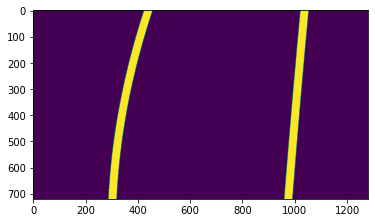

In [37]:


plt.imshow(outLines, 'gray')
plt.axis('off')
# plt.savefig('./Outputs/out.png', bbox_inches='tight', pad_inches = 0)

# Getting the lane ROI using Hough Transform

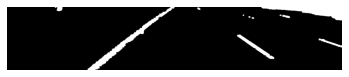

In [98]:
im = imgs[0]
height, width = im.shape[:2]

im_crop = im[horizon:,:, :]
out = mask(im_crop, 2, False)
plt.imshow(out, 'gray')
plt.axis('off')
plt.savefig('./Outputs/cropLane.png', bbox_inches='tight', pad_inches = 0)

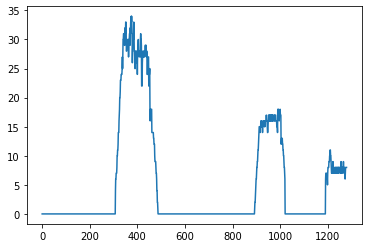

In [99]:
distribution  = np.sum(out[out.shape[0]//2:,:],axis=0)
mdpt = int(len(distribution)//2) # find midpoint of the distribution alonf x axis    
Xcleft = np.argmax(distribution[:mdpt]) # find left lane peak as p1
Xcright = np.argmax(distribution[mdpt:]) + mdpt # find right lane peak as p2 

plt.plot(distribution)
plt.savefig('./Outputs/LaneDist.png', bbox_inches='tight', pad_inches = 0)

In [96]:
vanishROI = np.zeros_like(out)
vanishROI[:,Xcleft-100:Xcright+100] = out[:,Xcleft-100:Xcright+100]

minLineLength = 280
lines =np.squeeze(cv2.HoughLinesP(vanishROI, 2, np.pi / 180, 100,  
                            np.array([]), minLineLength = minLineLength,  
                            maxLineGap = 10))

line_image = np.zeros_like(vanishROI)
if lines is not None: 
    for x1, y1, x2, y2 in lines: 
        cv2.line(line_image, (x1, y1), (x2, y2), 255, 10) 

v_l, v_r = vanishingLineEndPoints(lines)

d_bot1, d_bot2, d_top1, d_top2 = (100,100,20,20)

b_left, b_right = Xcleft- d_bot1, Xcright+d_bot2 ## edit to change ROI
t_left, t_right = v_l[0] -d_top1, v_r[0] +d_top2 ## edit to change ROI

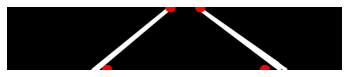

In [97]:
pts1 = np.array([[Xcleft,line_image.shape[0]],[v_l[0],0],[v_r[0],0], [Xcright, line_image.shape[0]]], np.float32)

line_print1 = drawCircles(binary2color(line_image*255),pts1, 20)
plt.imshow(line_print1)
plt.axis('off')
plt.savefig('./Outputs/houghLanes.png', bbox_inches='tight', pad_inches = 0)

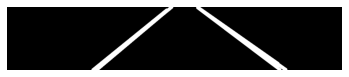

In [102]:
plt.imshow(line_image,'gray')
plt.axis('off')
plt.savefig('./Outputs/houghLanes1.png', bbox_inches='tight', pad_inches = 0)

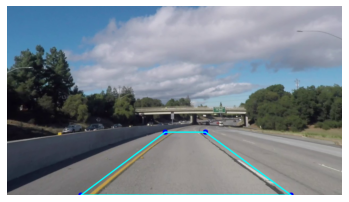

In [81]:
pts = np.array([[b_left,height],[t_left,horizon],[t_right,horizon], [b_right, height]], np.float32)
im_print = drawCircles(im,pts, 10)
im_print = cv2.polylines(im_print,[np.int32(pts)],True,(0,255,255), 3)

plt.imshow(im_print)
plt.axis('off')
plt.savefig('./Outputs/houghROI.png', bbox_inches='tight', pad_inches = 0)

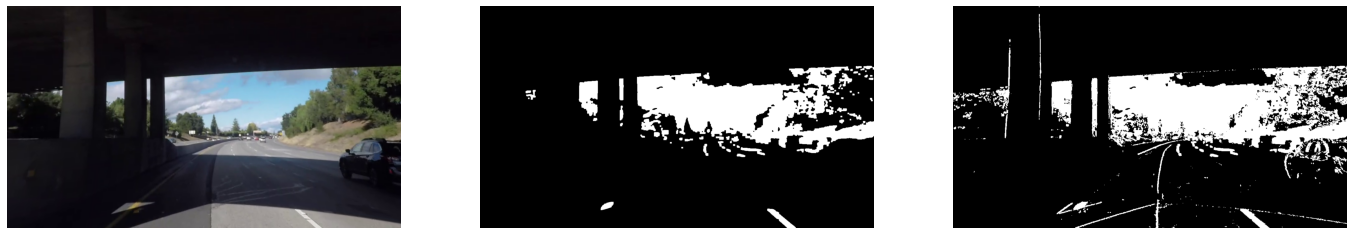

In [38]:
fig , plts = plt.subplots(1,3, figsize = (24,20))
plts[0].imshow(im)
plts[0].axis('off')
plts[1].imshow(binary2color(binary_))
plts[1].axis('off')
plts[2].imshow(binary2color(binary))
plts[2].axis('off')

plt.savefig('./Outputs/gradThresh.png', bbox_inches='tight', pad_inches = 0)

In [8]:
K = np.array([9.037596e+02, 0.000000e+00, 6.957519e+02,
              0.000000e+00, 9.019653e+02, 2.242509e+02,
              0.000000e+00, 0.000000e+00, 1.000000e+00]).reshape(3,3)

kC = np.array([-3.639558e-01, 1.788651e-01, 6.029694e-04, -3.922424e-04, -5.382460e-02]).reshape(1,-1)

path = "./Project2_Dataset2/Project2_Dataset2/data_2/challenge_video.mp4"
imgs = vidRead(K,kC, path)



boundaries = (200,1200,600,730) 
horizon = 480
window_size = 250
mva_filter = True
mva_win = 10
lanecenter = 600

detector = LaneDetector(horizon, boundaries, window_size, mva_filter, mva_win, lanecenter)
outputs = []
h, w = imgs[0].shape[:2]
print(h,w)
SaveFileName = 'challengeoutput.mp4'
result = cv2.VideoWriter(SaveFileName,  
                        cv2.VideoWriter_fourcc(*'DIVX'), 
                        10, (h, w)) 

for i, im in enumerate(imgs):
    print(i, '####################################')
    out = detector.processLane(im)

    cv2.imshow('Lanes', rgb(out))
    result.write(out)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    outputs.append(out)
cv2.destroyAllWindows()    

720 1280
0 ####################################
initialised moving average
w/o lane width restriction :  318 977 -##- with lane width restriction :  318 977
mean Window lengths 1 1
No of lane pixels detected:  8829 8829 3639 3639
added mean lines
1 ####################################
w/o lane width restriction :  317 976 -##- with lane width restriction :  317 976
mean Window lengths 2 2
No of lane pixels detected:  8711 8711 3721 3721
added mean lines
2 ####################################
w/o lane width restriction :  318 970 -##- with lane width restriction :  318 970
mean Window lengths 3 3
No of lane pixels detected:  8592 8592 3263 3263
added mean lines
3 ####################################
w/o lane width restriction :  318 970 -##- with lane width restriction :  318 970
mean Window lengths 4 4
No of lane pixels detected:  8139 8139 2915 2915
added mean lines
4 ####################################
w/o lane width restriction :  320 965 -##- with lane width restriction :  320 965

# Code 

In [12]:
print(len(imgs))

303


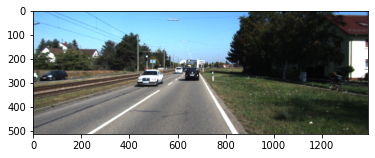

In [23]:
im = imgs[200]
plt.imshow(im)

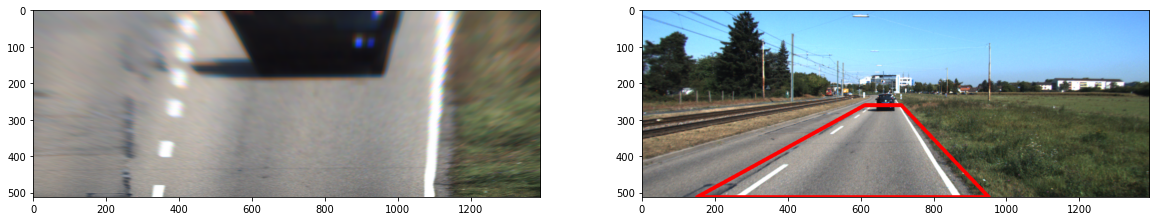

In [33]:
def PerspectiveTransform_(im,horizon,boundaries,inverse=False, ismanual = True):
    
    d_bot1, d_bot2, d_top1, d_top2 = boundaries

    im_print = np.copy(im)
    height,width = im.shape[:2]


    minLineLength = 300
    if ismanual == False:
        pts = getROI_points(im_print, horizon, minLineLength ,d_bot1, d_bot2,d_top1,d_top2) # challenge video
    else:
        pts = np.array([[d_bot1,height],[d_top1, horizon],[d_top2, horizon], [d_bot2, height]], np.float32)
#         pts = np.array([[a,height],[int(width*b - d_top1),self.horizon],[int(width*(1-b)+d_top2),self.horizon], [width-a, height]], np.float32)

    dst_w, dst_h =width, height
    c =200
    res = np.array([[c, dst_h], [c, 0], [width-c, 0], [width-c, dst_h]], np.float32)
#     res = np.array([[(a+100), height], [(a+100), 0], [width-(a+100), 0], [width-(a+100), height]], np.float32)

    if len(im_print.shape)<3:
        cv2.polylines(im_print,[np.int32(pts)],True,1, 10)    
    else:
        cv2.polylines(im_print,[np.int32(pts)],True,(255,0,0), 10)

    if inverse == True:
        M = cv2.getPerspectiveTransform(res, pts)
        im_warp = cv2.warpPerspective(im, M, (width,height), flags=cv2.INTER_LINEAR)

    else:   
        M = cv2.getPerspectiveTransform(pts, res)
        im_warp = cv2.warpPerspective(im, M, (dst_w,dst_h), flags=cv2.INTER_LINEAR)

    return im_warp, im_print

boundaries = (150,950,610,710) 
horizon = 260
window_size = 100

im_warp, im_print = PerspectiveTransform_(im,horizon,boundaries,inverse=False, ismanual = True)  
f,plts = plt.subplots(1,2, figsize = (20,10))
plts[0].imshow(im_warp)
plts[1].imshow(im_print)

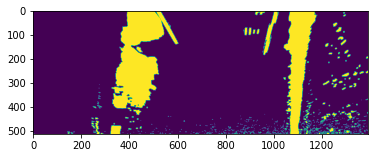

In [34]:
out_warp = mask(im_warp, grad = True)
plt.imshow(out_warp)

In [44]:
# boundaries = (150,950,610,710) 
# horizon = 260
# window_size = 200
# mva_filter = True
# mva_win = 3



boundaries = (200,1200,600,730) 
horizon = 480
window_size = 250
mva_filter = True
mva_win = 10
lanecenter = 600

detector = LaneDetector(horizon, boundaries, window_size, mva_filter, mva_win)
outputs = []
h, w = imgs[0].shape[:2]
print(h,w)
SaveFileName = 'challengeoutput.mp4'
result = cv2.VideoWriter(SaveFileName,  
                        cv2.VideoWriter_fourcc(*'DIVX'), 
                        10, (h, w)) 

for i, im in enumerate(imgs):
    print(i, '####################################')
    out = detector.processLane(im)

    cv2.imshow('Lanes', rgb(out))
    result.write(out)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    outputs.append(out)
cv2.destroyAllWindows()    

512 1392
0 ####################################
initialised moving average
w/o lane width restriction :  260 1140 -##- with lane width restriction :  260 1140
mean Window lengths 1 1
No of lane pixels detected:  11537 11537 12996 12996
added mean lines
1 ####################################
w/o lane width restriction :  257 1145 -##- with lane width restriction :  257 1145
mean Window lengths 2 2
No of lane pixels detected:  14212 14212 12897 12897
added mean lines
2 ####################################
w/o lane width restriction :  260 1149 -##- with lane width restriction :  260 1149
mean Window lengths 3 3
No of lane pixels detected:  15038 15038 11627 11627
added mean lines
3 ####################################
w/o lane width restriction :  268 1152 -##- with lane width restriction :  268 1152
mean Window lengths 4 4
No of lane pixels detected:  18501 18501 11538 11538
added mean lines
4 ####################################
w/o lane width restriction :  210 1156 -##- with lane wid

In [76]:
l1 = detector.e_L_line
l2 = detector.e_R_line

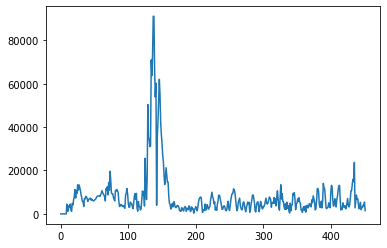

In [86]:
plt.plot(l2)

In [ ]:
def main():
    
    Parser = argparse.ArgumentParser()
    Parser.add_argument('--SaveName', default='Tag0', help='Video input name , Default:Tag0')
    Parser.add_argument('--VideoPath', default='../Data/Tag0.mp4', help='Video path , Default:../Data/Tag0.mp4')
    
    Parser.add_argument('--SavePath', default='../Outputs/Problem2/', help='Video Save Path , Default: .../Outputs/Problem2/')
    
    Args = Parser.parse_args()
    SaveName = Args.SaveName
    VideoPath = Args.VideoPath
    SavePath = Args.SavePath
    if(not (os.path.isdir(SavePath))):
        os.makedirs(SavePath)
    
    outputs, lastImage = ProcessVideo(VideoPath,TemplatePath)
    
    out = cv2.VideoWriter(SavePath+str(SaveName)+'_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, (800,640))
    for i in range(len(outputs)):
        out.write(outputs[i])
    out.release()
    
#     outVideo = mpy.ImageSequenceClip(outputs, fps=25)  ## use moviepy package to write a smoother video
#     outVideo.write_videofile(SavePath+str(SaveName)+'_output.mp4')
    
    if lastImage is not None:
        cv2.imwrite(SavePath+SaveName+'_result.png',lastImage)
        
        
if __name__ == '__main__':
    main()

473

mean Window lengths 7 5
w/o lane width restriction :  310 898 -##- with lane width restriction :  310 898
21247 21247 101876 101876
21247 21247 101876 101876


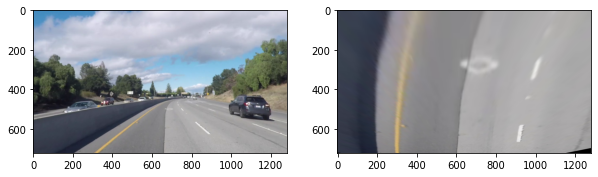

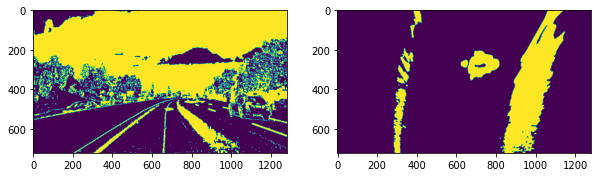

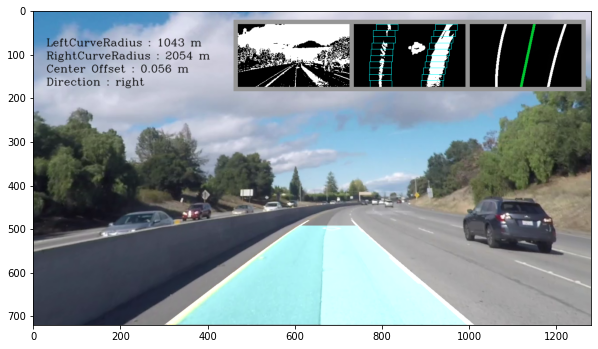

In [16]:
if startFlag ==True:
    l_mean = MovingAverage(window_size = 10)
    r_mean = MovingAverage(window_size = 10)

boundaries = (200,1200,600,730) 
a = 100
horizon =480

im_warp, im_print = PerspectiveTransform(im, a, horizon, boundaries, inverse=False, ismanual = True)  

fig,plts = plt.subplots(1,2,figsize = (10,5))
plts[0].imshow(im)
plts[1].imshow(im_warp)

out = mask(im, True)
out_warp = mask(im_warp, False)

fig,plts = plt.subplots(1,2,figsize = (10,5))
plts[0].imshow(out)
plts[1].imshow(out_warp)

print("mean Window lengths", l_mean.getListLength() , r_mean.getListLength())

[lX,lY],[rX,rY], window_img = windowTrace(out_warp, startFlag)

print(len(lX), len(lY), len(rX), len(rY))
## if bad data occurs,  use previous lane data
if (len(lX) ==0) or (len(lY)==0):
    lX,lY = prevL_pts
if (len(rX) ==0) or (len(rY)==0):
    rX,rY = prevR_pts

if len(lX) and len(lY) and len(rX) and len(rY):
#     L_line, R_line = fitLaneCurves(lX,lY,rX,rY)
    prevL_pts,prevR_pts = (lX,lY),(rX,rY)
print(len(prevL_pts[0]), len(prevL_pts[1]), len(prevR_pts[0]), len(prevR_pts[1]))

L_line, R_line = fitLaneCurves(lX,lY,rX,rY, out_warp.shape[0],0)

imLines = drawLaneLines(out_warp,L_line,R_line) # draw the estimated lane line 
line,direction = getDirection(L_line,R_line) # get the center line with mean of left and right lanes

inv_imLines1, _ = PerspectiveTransform(imLines, a, horizon, boundaries, inverse=True, ismanual = True) # get the unwarped estimated lane line 
# inv_im_warp,_ = PerspectiveTransform(out_warp,a, horizon, boundaries, inverse=True, ismanual = True) # get actual unwarped lanes

imL = np.dstack((imLines,imLines,imLines))

area_h = 200
inv_imColorLane = drawLaneArea(im,imL,L_line,R_line,area_h, a, horizon, boundaries)

# draw center Line
imL = cv2.polylines(imL, [line], False,  (0,200, 50), 30)

LeftCurveRadius,RightCurveRadius,RealLaneCenterOffset = getLaneStats(line,L_line,R_line)

outputFrame = createOutputFrame(inv_imColorLane,out, imL, window_img, LeftCurveRadius, RightCurveRadius, RealLaneCenterOffset, direction)
    
    
plt.figure(figsize = (10,10))
plt.imshow(outputFrame)